In [3]:
import sys
if sys.version_info >= (3, 5):
    from importlib.util import spec_from_file_location
import gc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

# The Data

Split the dataset in to train and test. We are using training data only for EDA.

In [4]:
df = pd.read_csv('train.tsv', sep = '\t')

In [8]:
msk = np.arange(len(df)) <  len(df) * 0.8

train = df[msk]
test = df[~msk]

In [9]:
train.shape, test.shape

((800, 8), (200, 8))

# EDA

In [10]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 0 to 799
Data columns (total 8 columns):
train_id             800 non-null int64
name                 800 non-null object
item_condition_id    800 non-null int64
category_name        797 non-null object
brand_name           462 non-null object
price                800 non-null float64
shipping             800 non-null int64
item_description     800 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 56.2+ KB


## Price

In [12]:
train.price.describe()

count    800.00000
mean      27.20500
std       43.76528
min        3.00000
25%       10.00000
50%       16.00000
75%       29.25000
max      650.00000
Name: price, dtype: float64

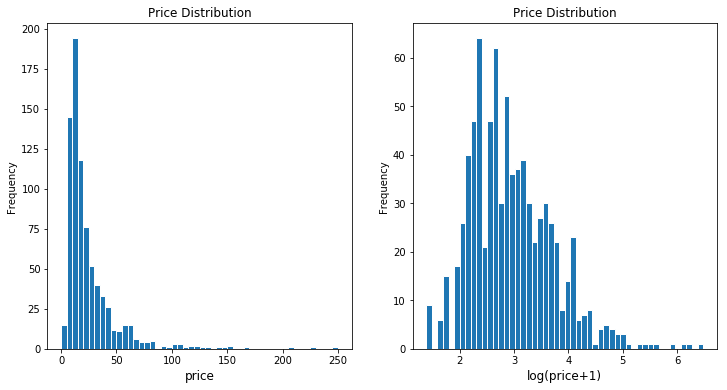

In [16]:
plt.subplot(1, 2, 1)
(train['price']).plot.hist(bins=50, figsize=(12, 6), edgecolor = 'white', range = [0, 250])
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)

plt.subplot(1, 2, 2)
np.log(train['price']+1).plot.hist(bins=50, figsize=(12,6), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Price Distribution', fontsize=12)
plt.show()

The price of items are left skewed, vast majority of items priced at 10-20. However, the most expensive item priced at 2009. So we make log-transformation on the price.

## Shipping

In [14]:
train['shipping'].value_counts() / len(train)

0    0.53625
1    0.46375
Name: shipping, dtype: float64

Over 55% of items shipping fee were paid by the buyers. How shipping related to price?

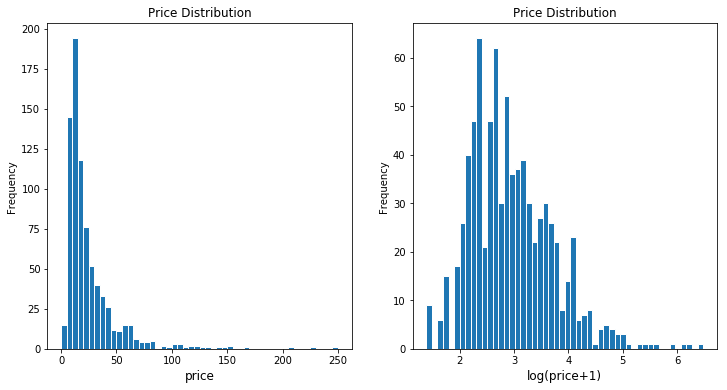

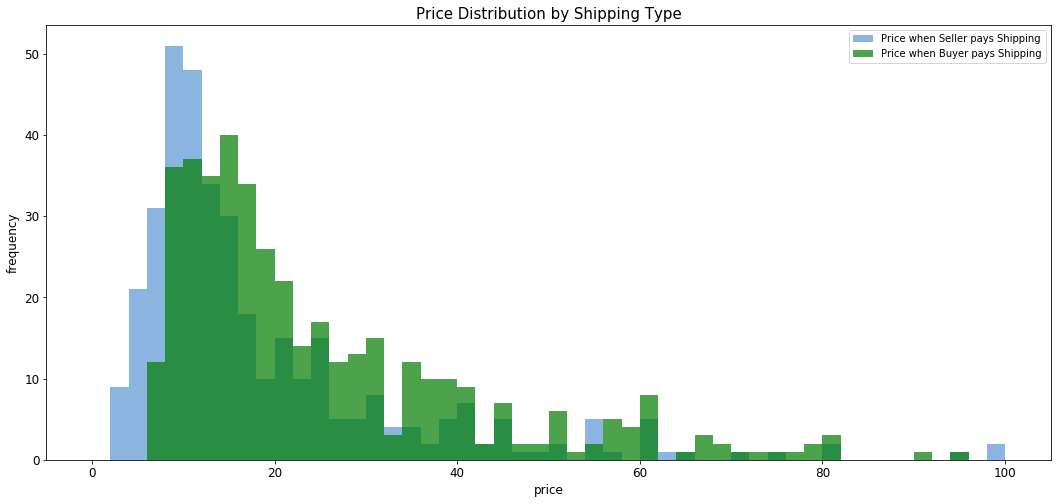

In [15]:
shipping_fee_by_buyer = train.loc[df['shipping'] == 0, 'price']
shipping_fee_by_seller = train.loc[df['shipping'] == 1, 'price']

fig, ax = plt.subplots(figsize=(18,8))
ax.hist(shipping_fee_by_seller, color='#8CB4E1', alpha=1.0, bins=50, range = [0, 100],
       label='Price when Seller pays Shipping')
ax.hist(shipping_fee_by_buyer, color='#007D00', alpha=0.7, bins=50, range = [0, 100],
       label='Price when Buyer pays Shipping')
plt.xlabel('price', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

In [17]:
print('The average price is {}'.format(round(shipping_fee_by_seller.mean(), 2)), 'if seller pays shipping');
print('The average price is {}'.format(round(shipping_fee_by_buyer.mean(), 2)), 'if buyer pays shipping')

The average price is 23.65 if seller pays shipping
The average price is 30.28 if buyer pays shipping


We compare again after log-transformation on the price.

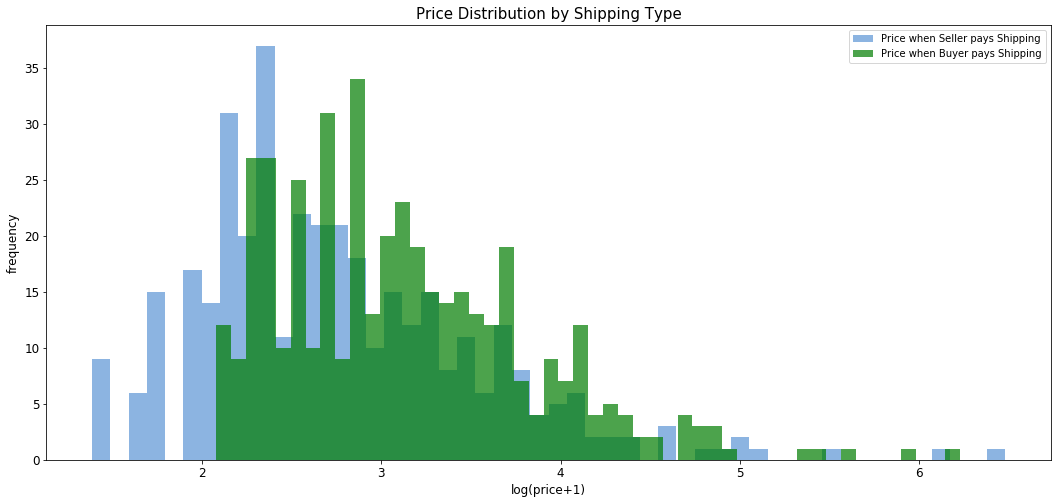

In [18]:
fig, ax = plt.subplots(figsize=(18,8))
ax.hist(np.log(shipping_fee_by_seller+1), color='#8CB4E1', alpha=1.0, bins=50,
       label='Price when Seller pays Shipping')
ax.hist(np.log(shipping_fee_by_buyer+1), color='#007D00', alpha=0.7, bins=50,
       label='Price when Buyer pays Shipping')
plt.xlabel('log(price+1)', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

It is obvious that the average price is higher when buyer pays shipping.

## Category Names

### Category names

In [19]:
print('There are', train['category_name'].nunique(), 'unique values in category name column')

There are 249 unique values in category name column


Top 10 most common category names

In [20]:
train['category_name'].value_counts()[:10]

Women/Athletic Apparel/Pants, Tights, Leggings    34
Beauty/Makeup/Eyes                                24
Women/Tops & Blouses/T-Shirts                     23
Beauty/Makeup/Lips                                21
Beauty/Makeup/Face                                19
Beauty/Fragrance/Women                            17
Women/Tops & Blouses/Blouse                       16
Women/Jewelry/Necklaces                           14
Women/Shoes/Boots                                 13
Men/Shoes/Athletic                                13
Name: category_name, dtype: int64

### Item condition vs. Price

In [21]:
sns.boxplot(x = 'item_condition_id', y = np.log(train['price']+1), data = train, palette = sns.color_palette('RdBu',5))


/Users/l_zhang/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/Users/l_zhang/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/Users/l_zhang/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/Users/l_zhang/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/Users/l_zhang/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is depre

In [22]:
set(train['item_condition_id'].values)


{1, 2, 3, 4, 5}

There seems to be various on the average price between each item condition id.

Therefore, we are going to use all the features to build our model.

# LightGBM

## Settings

In [23]:
NUM_BRANDS = 4000
NUM_CATEGORIES = 1000
NAME_MIN_DF = 10
MAX_FEATURES_ITEM_DESCRIPTION = 50000

There are missing values in the columns.

In [24]:
print('There are %d items that do not have a category name.' %train['category_name'].isnull().sum())

There are 3 items that do not have a category name.


In [25]:
print('There are %d items that do not have a brand name.' %train['brand_name'].isnull().sum())

There are 338 items that do not have a brand name.


In [26]:
print('There are %d items that do not have a description.' %train['item_description'].isnull().sum())

There are 0 items that do not have a description.


In [27]:
def handle_missing_inplace(dataset): 
    dataset['category_name'].fillna(value='missing', inplace=True) 
    dataset['brand_name'].fillna(value='missing', inplace=True) 
    dataset['item_description'].replace('No description yet,''missing', inplace=True) 
    dataset['item_description'].fillna(value='missing', inplace=True)

In [31]:
def cutting(dataset):
    pop_brand = dataset['brand_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_BRANDS]
    dataset.loc[~dataset['brand_name'].isin(pop_brand), 'brand_name'] = 'missing'
    pop_category = dataset['category_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_CATEGORIES]
    dataset.loc[~dataset['category_name'].isin(pop_category), 'category_name'] = 'missing'

In [32]:
def to_categorical(dataset):
    dataset['category_name'] = dataset['category_name'].astype('category')
    dataset['brand_name'] = dataset['brand_name'].astype('category')
    dataset['item_condition_id'] = dataset['item_condition_id'].astype('category')

In [33]:
df = pd.read_csv('train.tsv', sep = '\t')
msk = np.arange(len(df)) <  len(df) * 0.8

train = df[msk]
test = df[~msk]
test_new = test.drop('price', axis=1)
y_test = np.log1p(test["price"])

Drop rows where price = 0

In [34]:
train = train[train.price != 0].reset_index(drop=True)

In [35]:
nrow_train = train.shape[0]
y = np.log1p(train["price"])
merge = pd.concat([train, test_new], sort=False)

In [36]:
handle_missing_inplace(merge)
cutting(merge)
to_categorical(merge)

In [37]:
merge.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,missing,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,44.0,0,Complete with certificate of authenticity


Count vectorize name and category name columns.

In [38]:
cv = CountVectorizer(min_df=NAME_MIN_DF)
X_name = cv.fit_transform(merge['name'])

# print("merge namew:\n", merge['name'])

name = merge['name'].iloc[0:1]
print("name", name)
print("type name", type(name))

print("X_name.shape", X_name.shape)
print("X_name[0]", X_name[0])

X_name_array = X_name.toarray()
#print("x_name_array", X_name_array)
print("X_name_array.shape", X_name_array.shape)
#print("X_name_array[0]", X_name_array[0])


X_name0 = cv.transform(name)
print("X_name0:", X_name0)


name 0    MLB Cincinnati Reds T Shirt Size XL
Name: name, dtype: object
type name <class 'pandas.core.series.Series'>
X_name.shape (1000, 61)
X_name[0]   (0, 48)	1
  (0, 45)	1
X_name_array.shape (1000, 61)
X_name0:   (0, 45)	1
  (0, 48)	1


In [39]:
cv = CountVectorizer()
X_category = cv.fit_transform(merge['category_name'])

print("X_category.shape:", X_category.shape)

print("X_category[0]:", X_category[0])

ser_cat0 = merge['category_name'].iloc[0:1]
print(ser_cat0)

X_cat0 = cv.transform(ser_cat0)

print("X_cat0",X_cat0)
print("X_cat0.toarray",X_cat0.toarray())


X_category.shape: (1000, 348)
X_category[0]:   (0, 271)	1
  (0, 321)	1
  (0, 199)	1
0    Men/Tops/T-shirts
Name: category_name, dtype: category
Categories (276, object): [Beauty/Bath & Body/Bath, Beauty/Fragrance/Candles & Home Scents, Beauty/Fragrance/Women, Beauty/Hair Care/Conditioners, ..., Women/Women's Handbags/Other, Women/Women's Handbags/Shoulder Bag, Women/Women's Handbags/Totes & Shoppers, missing]
X_cat0   (0, 199)	1
  (0, 271)	1
  (0, 321)	1
X_cat0.toarray [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

TFIDF Vectorize item_description column.

In [40]:
tv = TfidfVectorizer(max_features=MAX_FEATURES_ITEM_DESCRIPTION, ngram_range=(1, 3), stop_words='english')
X_description = tv.fit_transform(merge['item_description'])

print("item_description 0")
ser_desc0 = merge['item_description'].iloc[1:2]
print(ser_desc0)

print("X_description.shape", X_description.shape)
print("X_description[0]", X_description[1])


X_desc0 = tv.transform(ser_desc0)

print("X_desc0.shape", X_desc0.shape)
print("X_desc0", X_desc0)

# 2 array is equal
(X_description[1] != X_desc0).nnz == 0

item_description 0
1    This keyboard is in great condition and works ...
Name: item_description, dtype: object
X_description.shape (1000, 29162)
X_description[0]   (0, 13184)	0.154384951068
  (0, 10856)	0.0713351137795
  (0, 6079)	0.0613065183586
  (0, 28622)	0.109893274342
  (0, 14080)	0.0757269182444
  (0, 4498)	0.130879071333
  (0, 3470)	0.0786226781762
  (0, 19425)	0.145709630241
  (0, 26053)	0.139554392159
  (0, 28589)	0.117910205566
  (0, 18525)	0.134780018584
  (0, 14064)	0.145709630241
  (0, 6866)	0.154384951068
  (0, 20524)	0.154384951068
  (0, 25588)	0.154384951068
  (0, 1576)	0.139554392159
  (0, 18322)	0.145709630241
  (0, 13185)	0.154384951068
  (0, 10873)	0.0868378527992
  (0, 6274)	0.154384951068
  (0, 28639)	0.154384951068
  (0, 14091)	0.154384951068
  (0, 4499)	0.154384951068
  (0, 3539)	0.154384951068
  (0, 19428)	0.154384951068
  (0, 26056)	0.145709630241
  (0, 28600)	0.154384951068
  (0, 18532)	0.154384951068
  (0, 14065)	0.154384951068
  (0, 6867)	0.154384951068
 

True

Label binarize brand_name column.

In [41]:
lb = LabelBinarizer(sparse_output=True)
X_brand = lb.fit_transform(merge['brand_name'])


ser_brand0 = merge['brand_name'].iloc[1:2]

print("ser_brand0")
print(ser_brand0)

print("X_brand.shape", X_brand.shape)
print("X_brand[0]", X_brand[1])

X_brand0 = lb.transform(ser_brand0)
print("X_brand0", X_brand0)



ser_brand0
1    Razer
Name: brand_name, dtype: category
Categories (230, object): [ALEX AND ANI, ASICS, ASUS, Acacia Swimwear, ..., missing, patagonia, rue, vineyard vines]
X_brand.shape (1000, 230)
X_brand[0]   (0, 170)	1
X_brand0   (0, 170)	1


Create dummy variables for item_condition_id and shipping columns.

In [43]:
X_dummies = csr_matrix(pd.get_dummies(merge[['item_condition_id', 'shipping']], sparse=True).values)

ser_dum0 = merge[['item_condition_id', 'shipping']].iloc[1:2]
print(ser_dum0)

merge[['item_condition_id', 'shipping']].info()

print("ser_dum0.values:",ser_dum0.values)
print("ser_dum0 type:",type(ser_dum0.values[0][0]))

print("X_dummies.shape", X_dummies.shape)
print("X_dummies[0]", X_dummies[1])



X_dummy0 = csr_matrix(pd.get_dummies(ser_dum0, sparse=True).values)

print("X_dummy0.shape", X_dummy0.shape)
print("X_dummy0", X_dummy0)





  item_condition_id  shipping
1                 3         0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 2 columns):
item_condition_id    1000 non-null category
shipping             1000 non-null int64
dtypes: category(1), int64(1)
memory usage: 16.8 KB
ser_dum0.values: [[3 0]]
ser_dum0 type: <class 'int'>
X_dummies.shape (1000, 6)
X_dummies[0]   (0, 3)	1
X_dummy0.shape (1, 6)
X_dummy0   (0, 3)	1


Create sparse merge.

In [44]:
sparse_merge = hstack((X_dummies, X_description, X_brand, X_category, X_name)).tocsr()

In [50]:
print(X_dummies.shape)
print(X_description.shape)
print(X_brand.shape)
print(X_category.shape)
print(X_name.shape)



sparse_merge.shape

(1000, 6)
(1000, 29162)
(1000, 230)
(1000, 348)
(1000, 61)


(1000, 3053)

Remove features with document frequency <=1.

In [46]:
mask = np.array(np.clip(sparse_merge.getnnz(axis=0) - 1, 0, 1), dtype=bool)
sparse_merge = sparse_merge[:, mask]

In [47]:
sparse_merge.shape

(1000, 3053)

Separate train and test data from sparse merge.

In [ ]:
X = sparse_merge[:nrow_train]
X_test = sparse_merge[nrow_train:]

In [ ]:
train_X = lgb.Dataset(X, label=y)

In [ ]:
params = {
        'learning_rate': 0.75,
        'application': 'regression',
        'max_depth': 3,
        'num_leaves': 100,
        'verbosity': -1,
        'metric': 'RMSE',
    }

### Training
Training a model requires a parameter list and data set. And training will take a while.

In [ ]:
gbm = lgb.train(params, train_set=train_X, num_boost_round=3200, verbose_eval=100)

### Prediction

In [ ]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [ ]:
from sklearn.metrics import mean_squared_error
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)